In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import random
# random.seed(0)

%matplotlib inline

## cpuを利用する場合
GPUが占拠されていて軽いテストだけ行いたい場合にはカーネルの環境変数を書き換える。<br>
そのために以下を実行

In [2]:
# import os
# os.environ['CUDA_VISIBLE_DEVICES']='-1'
# import keras

In [3]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='0'
import keras

/home/inouelab/.conda/envs/zukapy35/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator

In [5]:
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input,Layer,Lambda
from keras.layers import Flatten,BatchNormalization
from keras.layers import Dense,Dropout
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras import backend as K

## Hyper Parameters

In [6]:
imheight = 128
imwidth = 128
channels = 3
# ALPHA = 0.2
ALPHA=0.05

In [7]:
from keras.applications.vgg16 import VGG16
#include_top=false => Dense不要
base_model = VGG16(include_top=False, weights='imagenet', input_tensor=Input(shape=(imwidth, imheight, channels)), input_shape=None) 

In [8]:
for layer in base_model.layers[:15]:
    layer.trainable=False

In [9]:
def create_embNet():
    x = base_model.output
    conv1 = Conv2D(32, (4,4) , padding='same', activation='relu')(x)
    conv2 = Conv2D(32, (4,4) , padding='same', activation='relu')(conv1)
    flatten = Flatten()(conv2) 
    dense_layer = Dense(20, activation='relu')(flatten)
    norm_layer = Lambda(lambda  x: K.l2_normalize(x, axis=1), name='norm_layer')(dense_layer)
    return  Model(inputs=[base_model.input], outputs=norm_layer)

In [10]:
# define three Inputs
a_in = Input(shape = (imheight, imwidth, channels), name='anchor_input')
p_in = Input(shape = (imheight, imwidth, channels), name='positive_input')
n_in = Input(shape = (imheight, imwidth, channels), name='negative_input')

In [11]:
con_embNet = create_embNet()
shop_embNet = create_embNet()

In [12]:
a_emb = shop_embNet(a_in)
p_emb = con_embNet(p_in)
n_emb = con_embNet(n_in)

In [13]:
class TripletLossLayer(Layer):
    def __init__(self, alpha, **kwargs):
        self.alpha = alpha
        super(TripletLossLayer, self).__init__(**kwargs)
    
    def triplet_loss(self, inputs):
        a, p, n = inputs
        p_dist = K.sum(K.square(a-p), axis=-1)
        n_dist = K.sum(K.square(a-n), axis=-1)
        return K.sum(K.maximum(p_dist - n_dist + self.alpha, 0), axis=0)
    
    def call(self, inputs):
        loss = self.triplet_loss(inputs)
        self.add_loss(loss)
        return loss
    
    def get_config(self):
        config = {'alpha': self.alpha}
        base_config = super(TripletLossLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [14]:
# Layer that computes the triplet loss from anchor, positive and negative embedding vectors
triplet_loss_layer = TripletLossLayer(alpha=ALPHA, name='triplet_loss_layer')([a_emb, p_emb, n_emb])

# Model that can be trained with anchor, positive negative images
tripletNet = Model([a_in, p_in, n_in], triplet_loss_layer)

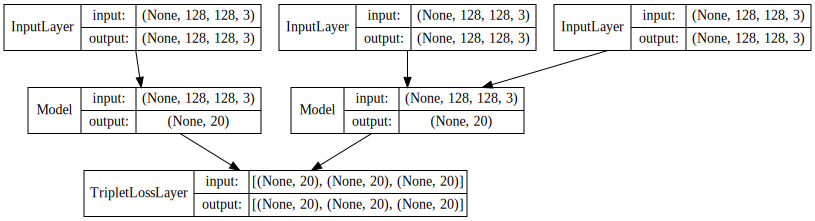

In [15]:
# output as image
plot_model(tripletNet, show_shapes=True,  show_layer_names=False, to_file='./readme_imgs/vgg/tripletNet.png')

# output on jupyter
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(tripletNet, show_shapes=True, show_layer_names=False).create(prog='dot', format='svg'))

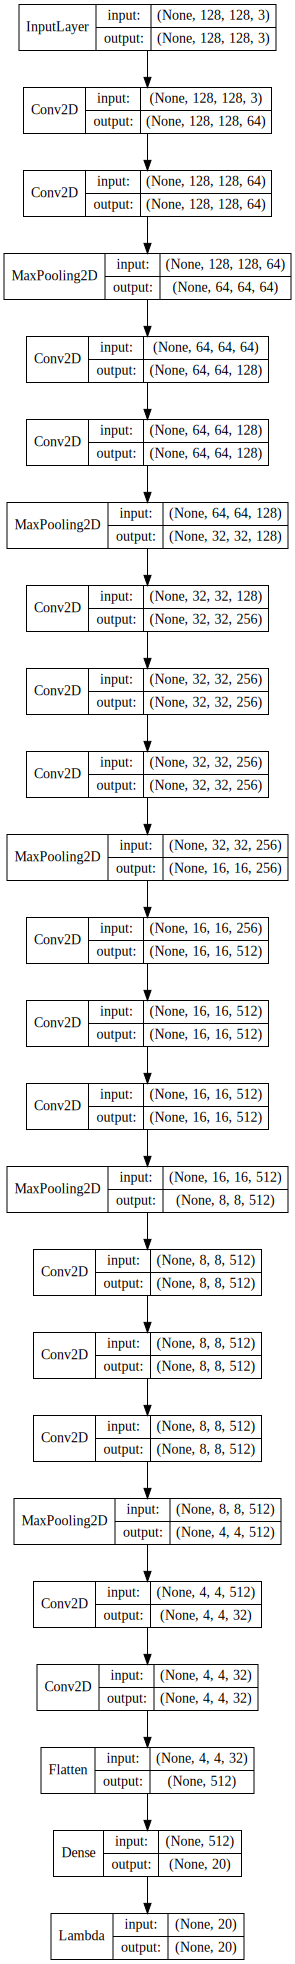

In [16]:
# plot embNet
plot_model(con_embNet, show_shapes=True,  show_layer_names=False, to_file='./readme_imgs/vgg/embNet.png') # to image
SVG(model_to_dot(con_embNet, show_shapes=True, show_layer_names=False).create(prog='dot', format='svg')) #on jupyter

In [17]:
con_embNet.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0         
__________

## "make_Triplet.ipynb"で作成したtripletの読み込み
- 画像サイズは読み込んでからリサイズすることで統一している

In [18]:
# # data = np.load('./np_datasets/T_Shirt/tshirt_pad_triplets.npy')
# data = np.load('./np_datasets/T_Shirt/NE_tshirt_triplets.npy')

In [19]:
# len(data)

In [20]:
# target = data[0][0]*255
# print(target.shape,type(target))
# pilImg = Image.fromarray(np.uint8(target))
# plt.imshow(pilImg.resize((128,128)))
# plt.show()

リサイズしてtripletを再構成

In [21]:
# import numpy as np
# triplets_ = []
# # triplets = np.ndarray
# for triplet in data:
    
#     anc_img = Image.fromarray(np.uint8(triplet[0])).convert('RGB')
#     pos_img = Image.fromarray(np.uint8(triplet[1])).convert('RGB')
#     neg_img = Image.fromarray(np.uint8(triplet[2])).convert('RGB')
    
#     anc_img = np.array(anc_img.resize((128,128))) #resize to (128,128,3)
#     pos_img = np.array(pos_img.resize((128,128)))    
#     neg_img = np.array(neg_img.resize((128,128)))    
    
#     tri = [anc_img,pos_img,neg_img]
#     triplets_.append(np.array(tri))

# triplets = np.array(triplets_) 

In [22]:
# ファイルに出力
# np.save('./np_datasets/T_Shirt/dataNE_tshirt_triplets.npy', triplets)

In [23]:
# del triplets

## 学習

In [24]:
triplets = np.load('np_datasets/T_Shirt/128NE_tshirt_triplets.npy')
triplets.shape

(7040, 3, 128, 128, 3)

In [ ]:
#並列化
from keras.utils import multi_gpu_model
# tripletNet2 = multi_gpu_model(tripletNet,gpus=2)
# compile model
tripletNet.compile(loss=None, optimizer='adam')

# fit model
# tripletNet.fit([triplets[:,0],triplets[:,1],triplets[:,2]], epochs=10, steps_per_epoch=100)
tripletNet.fit([triplets[:,0],triplets[:,1],triplets[:,2]], epochs=10, batch_size=10) # using batch_size is better
tripletNet.save('./np_datasets/T_Shirt/NEtshirtNetTriplet.h5')

# save partial Network 
shop_embNet.save('./np_datasets/T_Shirt/NEtshirt_embNet_shop.h5')
con_embNet.save('./np_datasets/T_Shirt/NEtshirt_embNet_con.h5')
# embNet_n.save('./np_datasets/Blouse/blouse_embNet_n.h5')

Epoch 1/10
7040/7040 [==============================] - 575s 82ms/step - loss: 0.4621
Epoch 2/10
7040/7040 [==============================] - 573s 81ms/step - loss: 0.3714
Epoch 3/10
7040/7040 [==============================] - 571s 81ms/step - loss: 0.3291
Epoch 4/10
7040/7040 [==============================] - 574s 82ms/step - loss: 0.3057
Epoch 5/10
7040/7040 [==============================] - 572s 81ms/step - loss: 0.2859
Epoch 6/10
7040/7040 [==============================] - 571s 81ms/step - loss: 0.2738
Epoch 7/10
7040/7040 [==============================] - 573s 81ms/step - loss: 0.2638
Epoch 8/10
7040/7040 [==============================] - 573s 81ms/step - loss: 0.2485
Epoch 9/10
7040/7040 [==============================] - 572s 81ms/step - loss: 0.2477
Epoch 10/10
4050/7040 [================>.............] - ETA: 4:03 - loss: 0.2344